# Author: Dominika PIECHOTA, POLAND

## 1. Introduction & Project Setup

### Purpose of the analysis and general information

The purpose of this project is to **analyze user activity and behavior** in the context of interactions with **machine learning models (ML)** features in an IDE environment.  

The dataset covers a **three-month period (March–May 2025)** and contains **anonymized daily user activity logs**, including user IDs, license types, models and features used, as well as metrics related to **the number of requests (request_cnt)** and **credits spent (spent_amount)**.

---

#### Main objectives of the analysis:
- to examine **how users utilize** various ML models and IDE features,  
- to **identify behavior patterns** and user groups (clusters),  
- **comparing licenses, models, and features** in terms of effectiveness and costs,  
- analyzing **time trends** in activity and spending,  
- developing **data-driven recommendations** for product development, pricing policy, and feature prioritization.

---

#### Scope:
- **Exploratory Data Analysis (EDA)** — preliminary data exploration and visualization,  
- **user segmentation** (RFM),
- **comparison of licenses, models, and features**,  
- analysis of **trends over time**,  
- basic **forecasting of credit spending**.


### Requirements
 - pandas>=2.0.0
 - numpy>=1.24.0
 - matplotlib>=3.7.0
 - seaborn>=0.12.0
 - scipy>=1.10.0
 - scikit-learn>=1.3.0
 - statsmodels>=0.14.0
 - scikit-posthocs>=0.7.0



### Imports & Plot Settings


In [568]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import scikit_posthocs as sp

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 8

### Data Loading


In [569]:
df = pd.read_csv('da_internship_task_dataset.csv')
df.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


### Basic Information About Data


In [570]:
df.info()
df.describe()
print("Data set size:", df.shape)

print("\n\nLicenses:\t", df['license'].unique())
print("Models:\t\t", df['model'].unique())
print("Features:\t", df['feature'].unique())
print("Users (unique):\t", df['uuid'].nunique())
print("Number of days during which data was collected:", df['day_id'].nunique())
print("Date range:\t", df['day_id'].min(), "→", df['day_id'].max())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB
Data set size: (122746, 7)


Licenses:	 ['Premium' 'Basic' 'Enterprise' 'Standard']
Models:		 ['Model_A' 'Model_B' 'Model_D' 'Model_E' 'Model_C']
Features:	 ['Feature_1' 'Feature_2' 'Feature_3' 'Feature_5' 'Feature_4']
Users (unique):	 1866
Number of days during which data was collected: 92
Date range:	 2025-03-01 → 2025-05-31


### Data Cleaning 

**Removing outliers** allows to eliminate observations with extremely high values that could distort the results of statistical analysis and inference.

In this case, such large values are likely to be errors in the data, as their occurrence in actual use of the system is unlikely or even impossible.

In [571]:
df = df.dropna()
print("Data set size after deleting null values:", df.shape)

# converting dates to an easier-to-use data type
df['day_id'] = pd.to_datetime(df['day_id'])

# searching for outliers and removing them from the data set so that they do not distort the overall analysis results
z_scores = stats.zscore(df[['requests_cnt', 'spent_amount']])
outliers_mask = (np.abs(z_scores) > 3).any(axis=1)
df = df[~outliers_mask].copy()
print("Data set size after deleting outliers:", df.shape)

Data set size after deleting null values: (122746, 7)
Data set size after deleting outliers: (122297, 7)


## 2. Exploratory Data Analysis (EDA)

### Basic Summary & Statistics

In [572]:
summary = {
    "Total credits spent": df['spent_amount'].sum(),
    "Average Daily Requests": df.groupby('day_id')['requests_cnt'].sum().mean(),
    "Average Daily Spending": df.groupby('day_id')['spent_amount'].sum().mean(),
}

for k, v in summary.items():
    print(f"{k:30s} {v}")

Total credits spent            1276049.28
Average Daily Requests         57997.836956521736
Average Daily Spending         13870.100869565214


### Distributions of Requests and Spending

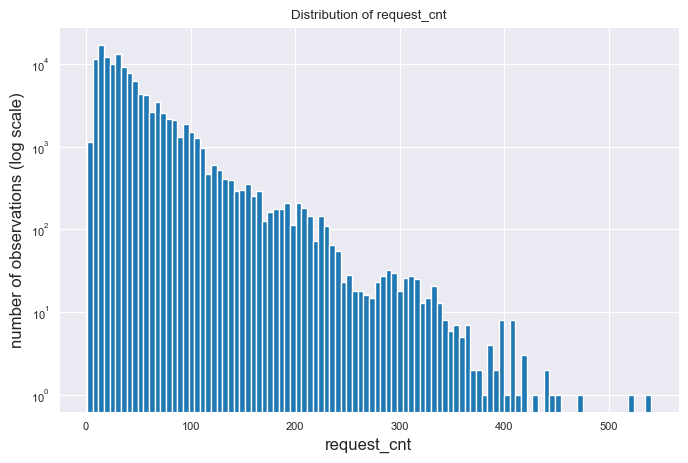

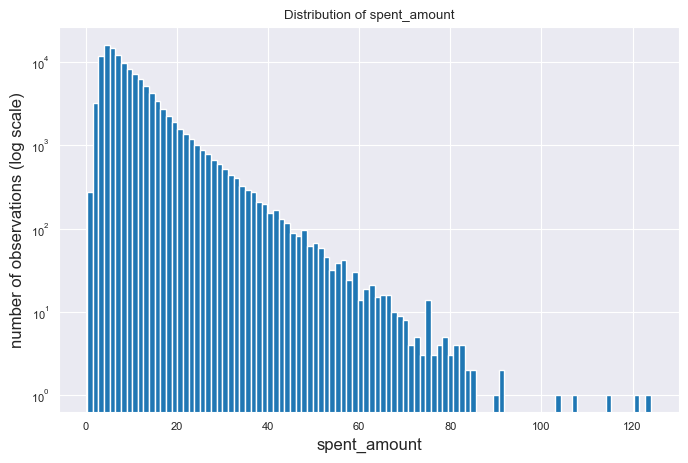

In [573]:
plt.hist(df['requests_cnt'], bins=100)
plt.title('Distribution of request_cnt')
plt.xlabel('request_cnt', fontsize=12)
plt.ylabel('number of observations (log scale)', fontsize=12)
plt.yscale('log')
plt.show()

plt.hist(df['spent_amount'], bins=100)
plt.title('Distribution of spent_amount')
plt.xlabel('spent_amount', fontsize=12)
plt.ylabel('number of observations (log scale)', fontsize=12)
plt.yscale('log')
plt.show()

Both graphs show **strong right-skewed** distributions, which means that:

 - most users make a small number of requests and spend little credit,
 - a small group of very active users generate a significant portion of the total activity and costs.

Using a logarithmic scale on the Y-axis allows us to better illustrate the differences between user groups and reveal the long-tail structure of the distribution.

This distribution is typical for SaaS systems and subscription-based environments — **a few users use the product intensively, while the majority show low activity**.

### Correlation between Number of Requests and Number of Credits Spent

Pearson correlation between requests_cnt and spent_amount: 0.8911


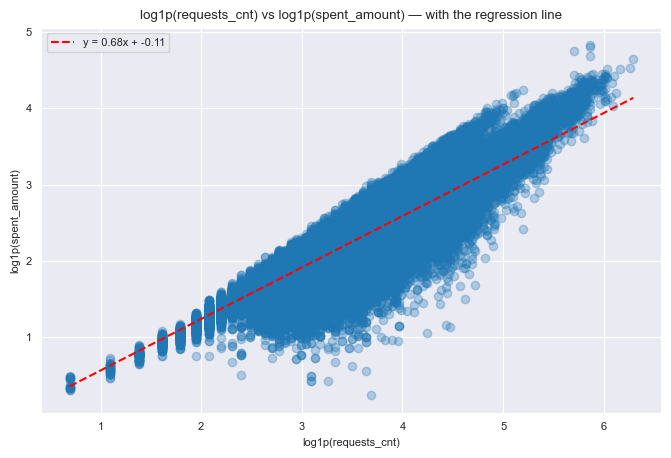

In [574]:
corr = df['requests_cnt'].corr(df['spent_amount'])
print(f"Pearson correlation between requests_cnt and spent_amount: {corr:.4f}")

# use log1p to deal with zeros
x = np.log1p(df['requests_cnt'])
y = np.log1p(df['spent_amount'])

# regression line
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

x_vals = np.linspace(x.min(), x.max(), 100)

plt.scatter(x, y, alpha=0.3)
plt.plot(x_vals, poly1d_fn(x_vals), color='red', linestyle='--', label=f'y = {coef[0]:.2f}x + {coef[1]:.2f}')
plt.xlabel('log1p(requests_cnt)')
plt.ylabel('log1p(spent_amount)')
plt.title('log1p(requests_cnt) vs log1p(spent_amount) — with the regression line')
plt.legend()
plt.show()

The correlation between the number of queries and credits spent (Pearson r ≈ 0.89) confirms that **user activity is directly related to spending**, suggesting a predictable relationship between usage intensity and resource consumption.


## 3. User Behavior & Segmentation

### RFM Segmentation - User Clusters

C:\Users\domin\anaconda3\envs\ML-projekty\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


,Users,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Spend
Cluster,,,,,
2,377,1.204244,103.543767,1695.158435,639074.730000
0,549,1.225865,97.234973,798.579362,438420.070000
4,455,1.059341,57.734066,384.564484,174976.840000
1,391,3.122762,8.138107,52.635013,20580.290000
3,79,17.936709,5.417722,37.941139,2997.350000


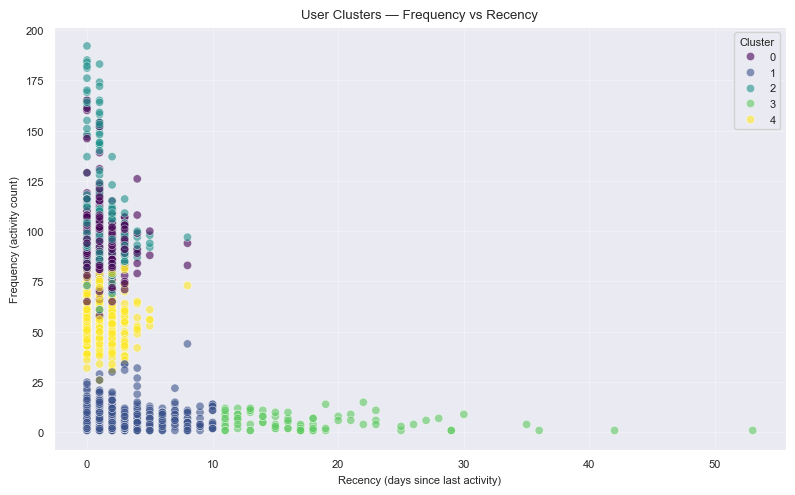

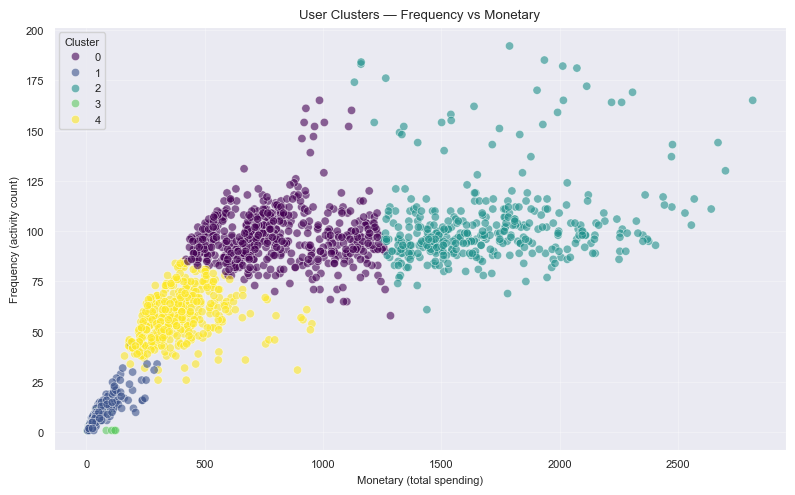

In [575]:
last_date = df['day_id'].max()
#RFM metrics
rfm = df.groupby('uuid').agg(
    Recency=('day_id', lambda x: (last_date - x.max()).days),
    Frequency=('day_id', 'count'),
    Monetary=('spent_amount', 'sum')
).reset_index()

# normalize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_summary = (
    rfm.groupby('Cluster')
    .agg(
        Users=('uuid', 'count'),
        Avg_Recency=('Recency', 'mean'),
        Avg_Frequency=('Frequency', 'mean'),
        Avg_Monetary=('Monetary', 'mean'),
        Total_Spend=('Monetary', 'sum')
    )
    .sort_values('Avg_Monetary', ascending=False)
)

display(rfm_summary.style.background_gradient(cmap="Blues"))

# plots
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Frequency',
    hue='Cluster',
    palette='viridis',
    alpha=0.6
)
plt.title('User Clusters — Frequency vs Recency')
plt.xlabel('Recency (days since last activity)')
plt.ylabel('Frequency (activity count)')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

sns.scatterplot(
    data=rfm,
    x='Monetary',
    y='Frequency',
    hue='Cluster',
    palette='viridis',
    alpha=0.6
)
plt.title('User Clusters — Frequency vs Monetary')
plt.xlabel('Monetary (total spending)')
plt.ylabel('Frequency (activity count)')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Based on three main dimensions of user activity:
- **Recency (R)** – number of days since last activity (measured on the last day for which we have data),
- **Frequency (F)** – frequency of activity,  
- **Monetary (M)** – total credit spending,

**K-Means** clustering was used, which allowed for the identification of **five distinct user groups** with different behavior patterns.

#### Cluster characteristics

- **Cluster 3 – Top Value Users**: very active and high-spending users — the core revenue group,
- **Cluster 1 – Good Users**: consistently active with high spending levels,
- **Cluster 2 – Regular Users**: active but use mainly low-cost or limited features,
- **Cluster 4 – Occasional Users**: infrequent activity and low spending — low overall engagement,
- **Cluster 0 – Inactive Users**: long-term inactive users who may need reactivation efforts,

#### Conclusions

The analysis reveals a clear polarization between **high-value users (Top Value and Good)** and groups with low engagement levels.  
Revenue value is still concentrated in a small number of clusters, confirming observed (in the next section) **Pareto** effect.  

#### Recommendations
- Focus marketing and product activities on **Top Value** and **Good Users** clusters, which generate the highest revenues.
- Implement **re-engagement mechanisms** (e.g., notifications, advertisements) for **Inactive/Ocassional** users.  
- Analyze transitions between clusters over time to track loyalty dynamics and early signs of declining activity.
- Use cluster profiling to personalize communications and offers, increasing retention effectiveness.

### Pareto Analysis & Lorenz Curve

Gini for total_spent: 0.4894815377968662


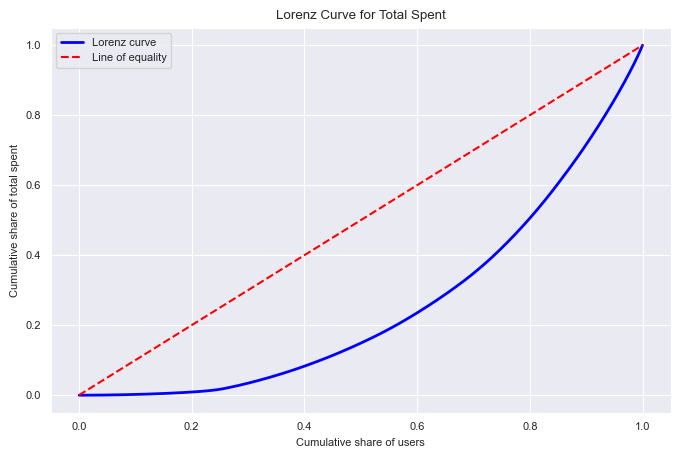

In [576]:
user_stats = df.groupby('uuid').agg(
    license_type=('license', 'first'),
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum'),
    first_day=('day_id', 'min'),
    last_day=('day_id', 'max'),
    n_days_active=('day_id', 'nunique')
).reset_index()

def gini(x):
    x = np.sort(x)
    n = len(x)
    return (2 * np.sum((np.arange(1, n+1) * x)) / (n * np.sum(x))) - (n + 1) / n

spent = user_stats['total_spent'].values
print("Gini for total_spent:", gini(spent))

# Lorenz Curve
sorted_spent = np.sort(spent)
n = len(sorted_spent)
cumulative_spent = np.cumsum(sorted_spent) / sorted_spent.sum()
cumulative_users = np.arange(1, n+1) / n

plt.plot(cumulative_users, cumulative_spent, label='Lorenz curve', color='blue', linewidth=2)
plt.plot([0,1], [0,1], label='Line of equality', color='red', linestyle='--')
plt.title('Lorenz Curve for Total Spent')
plt.xlabel('Cumulative share of users')
plt.ylabel('Cumulative share of total spent')
plt.legend()
plt.grid(True)
plt.show()

The use of the Lorenz Curve and the Gini Coefficient revealed a strong inequality in the distribution of user spending (Gini ≈ 0.5), which means that **a small percentage of users generate most of the revenue**.


## 4. License Usage & Upgrades

### License Summary

In [577]:
license_summary = (
    user_stats.groupby('license_type')
    .agg(
        n_users=('uuid', 'count'),
        total_requests=('total_requests', 'sum'),
        total_spent=('total_spent', 'sum'),
        avg_requests_per_user=('total_requests', 'mean'),
        avg_spent_per_user=('total_spent', 'mean'),
        share_requests=('total_requests', lambda x: x.sum()/user_stats['total_requests'].sum()*100),
        share_spent=('total_spent', lambda x: x.sum()/user_stats['total_spent'].sum()*100)
    )
    .reset_index()
)
display(license_summary)

,license_type,n_users,total_requests,total_spent,avg_requests_per_user,avg_spent_per_user,share_requests,share_spent
0,Basic,683,966540.0,231904.39,1415.139092,339.537906,18.114244,18.173623
1,Enterprise,247,1785971.0,425685.12,7230.651822,1723.421538,33.471469,33.359614
2,Premium,238,1306017.0,311270.20,5487.466387,1307.857983,24.476494,24.393274
3,Standard,683,1277273.0,307189.57,1870.092240,449.765110,23.937793,24.073488


### Cstomer Lifetime Summary (CLV)

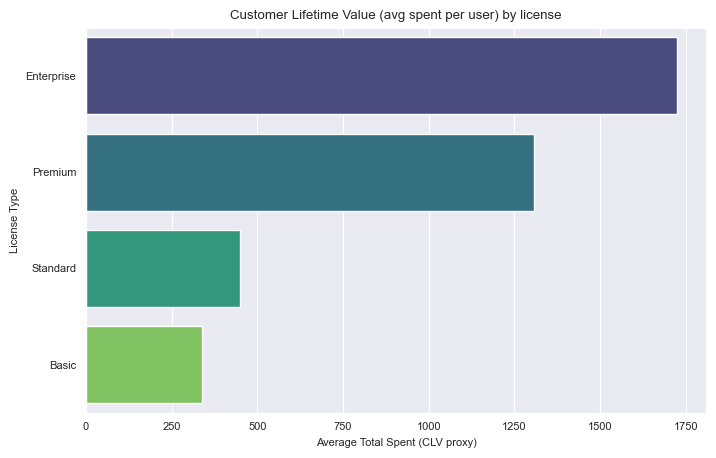

In [578]:
clv = user_stats.groupby('license_type')['total_spent'].mean().sort_values(ascending=False)
sns.barplot(x=clv.values, y=clv.index, hue = clv.index, palette="viridis", legend=False)
plt.title("Customer Lifetime Value (avg spent per user) by license")
plt.xlabel("Average Total Spent (CLV proxy)")
plt.ylabel("License Type")
plt.show()

It is easy to see that users with **premium or enterprise licenses use models much more** over their 'lifetime' than those with regular licenses. 

### Share of Total Requests by License, Model, and Feature

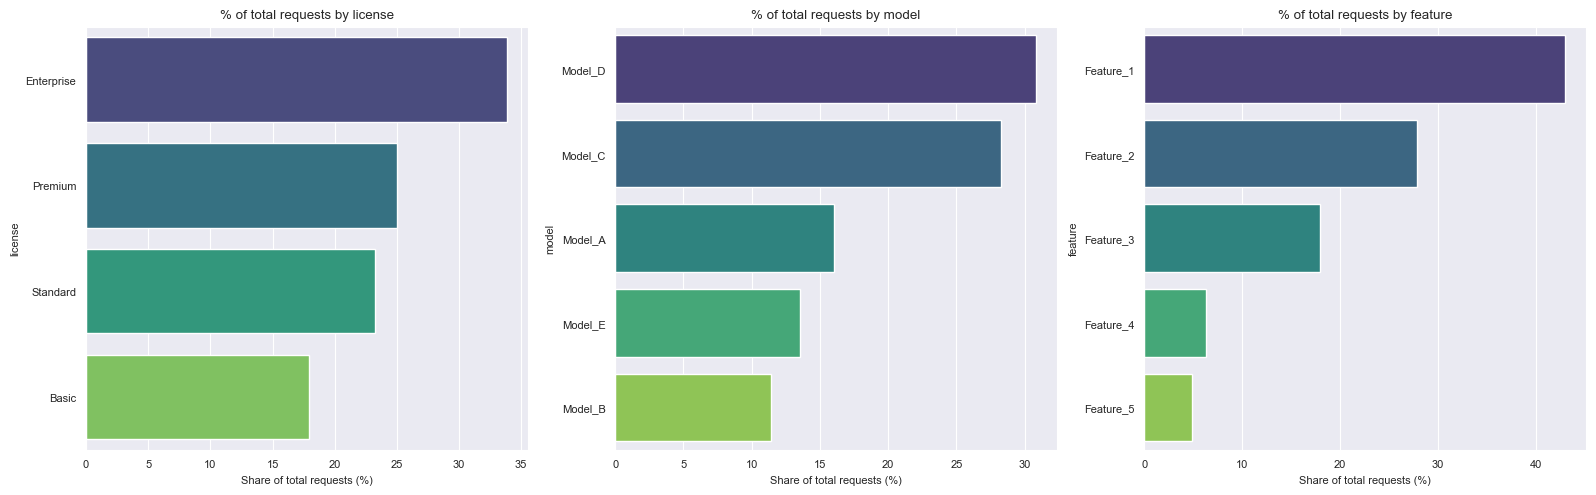

In [579]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for ax, col in zip(axes, ['license', 'model', 'feature']):
    share = df.groupby(col)['requests_cnt'].sum().sort_values(ascending=False)
    share_percent = (share / share.sum()) * 100
    sns.barplot(x=share_percent.values, y=share_percent.index, ax=ax, hue=share_percent.index, palette="viridis", legend=False)
    ax.set_title(f"% of total requests by {col}")
    ax.set_xlabel("Share of total requests (%)")
plt.tight_layout()
plt.show()


**Enterprise users generate the highest number of requests**, reflecting their elevated activity levels, although the overall differences between license types are relatively modest. This is because more advanced licenses have fewer subscribers than basic or standard versions, but they are more active.

As for models and features, the differences are bigger. **The most used model is definitely C and D**, while the **most used features are feature 1, followed by feature 2**.

### Does the number of credits spent depend on the type of license purchased?

In [580]:
# license vs spent credits amount (Kruskal-Wallis, pairwise Dunn test)
print("\nStatistical comparison: spent_amount by license type\n")

license_groups = [df.loc[df['license'] == lic, 'spent_amount'] for lic in df['license'].unique()]

# Kruskal–Wallis test
stat, p = kruskal(*license_groups)
print(f"Kruskal–Wallis H = {stat:.3f}, p-value = {p:.4f}")
if p < 0.05:
    print("→ Statistically significant differences between license groups (α = 0.05).")
else:
    print("→ No statistically significant differences between license groups.\n")

# post-hoc Dunn’s test (pairwise)
posthoc = sp.posthoc_dunn(df, val_col='spent_amount', group_col='license', p_adjust='bonferroni')
posthoc = posthoc.map(lambda x: f"{x:.6f}")

print("\nPairwise Dunn test (Bonferroni-adjusted p-values):")
print(posthoc)


Statistical comparison: spent_amount by license type

Kruskal–Wallis H = 56753.567, p-value = 0.0000
→ Statistically significant differences between license groups (α = 0.05).

Pairwise Dunn test (Bonferroni-adjusted p-values):
               Basic Enterprise   Premium  Standard
Basic       1.000000   0.000000  0.000000  0.000000
Enterprise  0.000000   1.000000  0.000000  0.000000
Premium     0.000000   0.000000  1.000000  0.000000
Standard    0.000000   0.000000  0.000000  1.000000


All comparisons between different license types yield **p-values close to 0**, which indicates **statistically significant differences** in spending between these groups.  
In other words, users with different license types differ significantly in terms of the amounts spent.

(It is worth noting that the values on the diagonal (comparison of a group with itself) are equal to 1, which is expected.)

### Does the average cost per request depend on the type of license purchased?

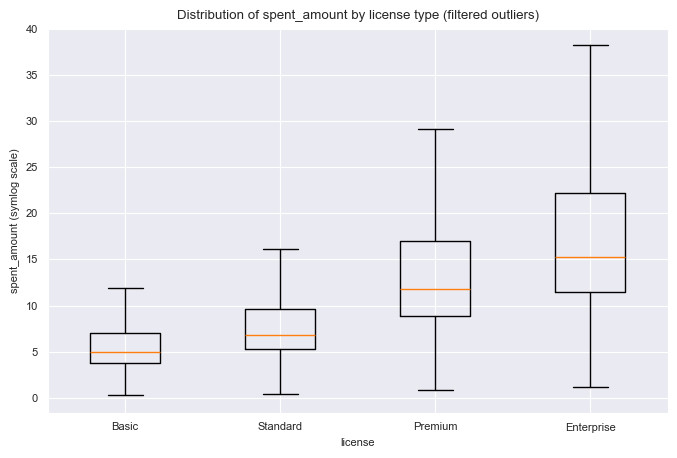

Kruskal–Wallis H = 56753.567, p-value = 0.000000
→ Statistically significant differences between license groups (α = 0.05).

Pairwise Dunn test (Bonferroni-adjusted p-values):


,Basic,Enterprise,Premium,Standard
Basic,1.000000,0.000000,0.000000,0.000000
Enterprise,0.000000,1.000000,0.000000,0.000000
Premium,0.000000,0.000000,1.000000,0.000000
Standard,0.000000,0.000000,0.000000,1.000000


,license,total_requests,total_spent,mean_requests,mean_spent,median_requests,median_spent,users,avg_cost_per_request,mean_pvalue_vs_others
0,Basic,956323.0,228119.28,24.441511,5.830227,20.0,4.92,711,0.238538,0.25
3,Standard,1241326.0,300995.99,33.366288,8.090638,28.0,6.85,701,0.242479,0.25
2,Premium,1333278.0,317919.11,59.238370,14.125344,49.0,11.84,245,0.238449,0.25
1,Enterprise,1804874.0,429014.90,76.934101,18.287080,63.0,15.27,251,0.237698,0.25


In [581]:
by_license = (
    df.groupby('license')
    .agg(
        total_requests=('requests_cnt', 'sum'),
        total_spent=('spent_amount', 'sum'),
        mean_requests=('requests_cnt','mean'),
        mean_spent=('spent_amount','mean'),
        median_requests=('requests_cnt','median'),
        median_spent=('spent_amount','median'),
        users=('uuid','nunique')
    )
    .reset_index()
)

by_license['avg_cost_per_request'] = by_license['total_spent'] / by_license['total_requests']

by_license = by_license.sort_values('total_spent', ascending=True)

# boxplots
licenses =by_license['license']
data_to_plot = [df.loc[df['license']==lic,'spent_amount'] for lic in licenses]
plt.boxplot(data_to_plot, tick_labels=licenses, showfliers=False)
plt.xlabel('license')
plt.ylabel('spent_amount (symlog scale)')
plt.title('Distribution of spent_amount by license type (filtered outliers)')
plt.show()

# data preparation for testing
license_groups = [df.loc[df['license'] == lic, 'spent_amount'] for lic in df['license'].unique()]

# Kruskal-Wallis test
stat, p = kruskal(*license_groups)
print(f"Kruskal–Wallis H = {stat:.3f}, p-value = {p:.6f}")

if p < 0.05:
    print("→ Statistically significant differences between license groups (α = 0.05).")
else:
    print("→ No statistically significant differences between license groups.\n")

# post-hoc Dunn’s test (pairwise)
posthoc = sp.posthoc_dunn(df, val_col='spent_amount', group_col='license', p_adjust='bonferroni')

posthoc = posthoc.map(lambda x: f"{x:.6f}")
print("\nPairwise Dunn test (Bonferroni-adjusted p-values):")
display(posthoc)

mean_pvalues = posthoc.map(float).mean(axis=1).round(6)
by_license['mean_pvalue_vs_others'] = mean_pvalues.values

display(by_license)

All pairwise comparisons show p < 0.05, indicating that every license pair differs significantly in terms of user spending.

 - **Enterprise and Premium users spend the most** — these are high-value commercial segments,

 - Standard and especially Basic users show much lower spending, reflecting lighter engagement or usage limits,

 - The fact that Enterprise vs Premium also differs significantly suggests that **even among commercial users, spending intensity varies**,

 - Additionally, higher-tier licenses show substantially greater variance in spending, indicating more diverse usage patterns among professional users — some may use advanced features heavily, while others only occasionally. This wider spread reflects the flexible and scalable nature of higher plans.



### Does the license type affect which model one uses?

Testing the relationship between the variables ‘license’ and 'model':
- chi² statistics = 41660.94, degrees of freedom = 12
- p-value = 0.0000 → statistically significant correlation (α = 0.05)
- Cramér’s V = 0.051 → correlation very weak




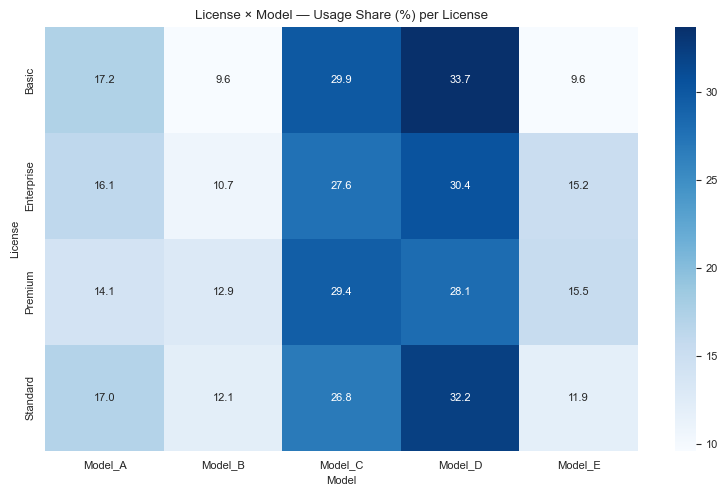

In [582]:
# contingency matrix: license x model
table = pd.crosstab(
    df['license'], 
    df['model'], 
    values=df['requests_cnt'], 
    aggfunc='sum',
    dropna=False
)

chi2, p, dof, expected = chi2_contingency(table)
n = table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(table.shape) - 1)))

# Cramér’s V interpretation
if cramers_v < 0.1:
    strength = "very weak"
elif cramers_v < 0.3:
    strength = "weak"
elif cramers_v < 0.5:
    strength = "moderate"
else:
    strength = "strong"

# interpretation of statistical significance
alpha = 0.05
significance = "significant" if p < alpha else "insignificant"

print("Testing the relationship between the variables ‘license’ and 'model':")
print(f"- chi² statistics = {chi2:.2f}, degrees of freedom = {dof}")
print(f"- p-value = {p:.4f} → statistically {significance} correlation (α = 0.05)")
print(f"- Cramér’s V = {cramers_v:.3f} → correlation {strength}\n\n")

# heatmap
table_pct = table.div(table.sum(axis=1), axis=0) * 100
sns.heatmap(table_pct, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title("License × Model — Usage Share (%) per License")
plt.xlabel("Model")
plt.ylabel("License")
plt.tight_layout()
plt.show()

There are differences between licenses in the use of models, however, the **correlation is extremely weak** and not worth further investigation.

All licenses select models more or less according to the same pattern; **no license prefers any particular model**. 

This strengthens the position of models C and D—they are the most popular and **frequently used by everyone** (queries for them account for over half of all requests).

### Does the license type affect which feature one uses?

Testing the relationship between the variables ‘license’ and 'feature':
- chi² statistics = 41660.94, degrees of freedom = 12
- p-value = 0.0000 → statistically significant correlation (α = 0.05)
- Cramér’s V = 0.051 → correlation very weak




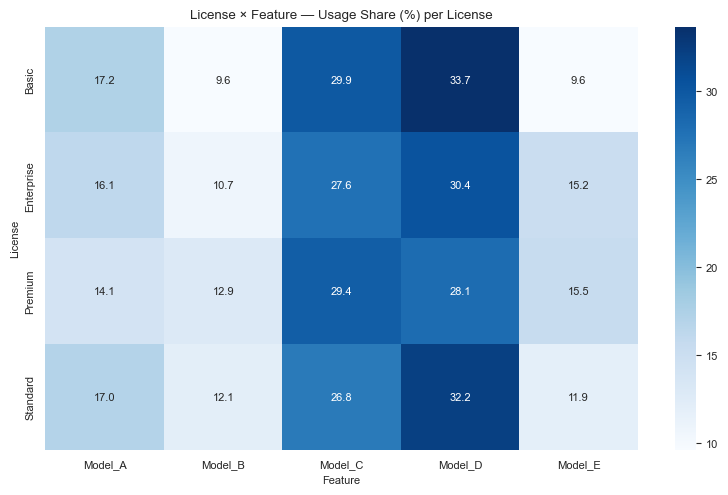

In [583]:
chi2, p, dof, expected = chi2_contingency(table)
n = table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(table.shape) - 1)))

# Cramér’s V interpretation
if cramers_v < 0.1:
    strength = "very weak"
elif cramers_v < 0.3:
    strength = "weak"
elif cramers_v < 0.5:
    strength = "moderate"
else:
    strength = "strong"

# Interpretation of statistical significance
alpha = 0.05
significance = "significant" if p < alpha else "insignificant"

print("Testing the relationship between the variables ‘license’ and 'feature':")
print(f"- chi² statistics = {chi2:.2f}, degrees of freedom = {dof}")
print(f"- p-value = {p:.4f} → statistically {significance} correlation (α = 0.05)")
print(f"- Cramér’s V = {cramers_v:.3f} → correlation {strength}\n\n")

# heatmap
table_pct = table.div(table.sum(axis=1), axis=0) * 100
sns.heatmap(table_pct, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title("License × Feature — Usage Share (%) per License")
plt.xlabel("Feature")
plt.ylabel("License")
plt.tight_layout()
plt.show()

There are differences between licenses in the use of features, however, the **correlation is extremely weak** and not worth further investigation.

All licenses select features more or less according to the same pattern; **no license prefers any particular feature**. 

This strengthens the position of features 1 and 2 — they are the most popular and frequently **used by everyone** (queries for them account for about 70% of all requests)

### License Upgrade Flows Over Time

,prev_license,license,users,share_%
2,Basic,Standard,27,47.4
3,Standard,Enterprise,10,17.5
1,Basic,Premium,8,14.0
0,Basic,Enterprise,7,12.3
4,Standard,Premium,5,8.8


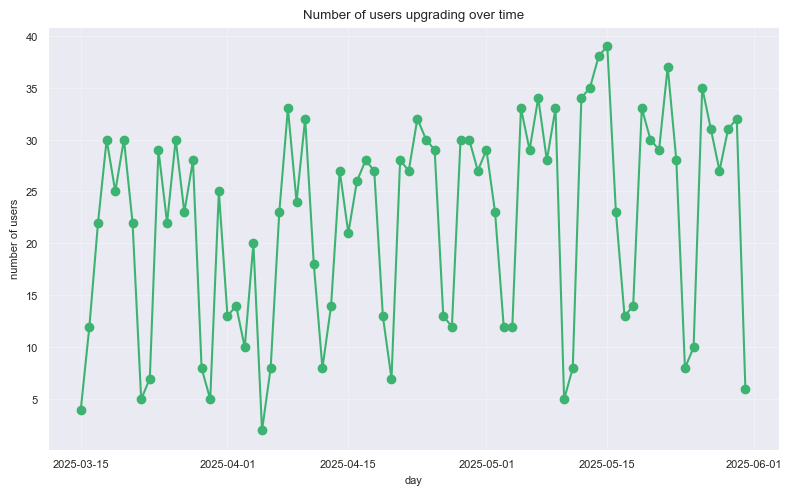

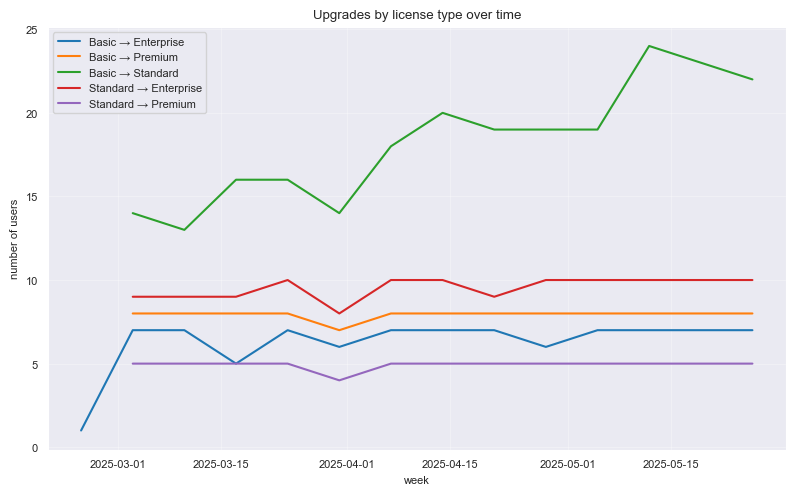

In [584]:
df = df.sort_values(['uuid', 'day_id']).copy()
df['prev_license'] = df.groupby('uuid')['license'].shift(1)
df['license_changed'] = df['license'] != df['prev_license']

license_order = ['Basic', 'Standard', 'Premium', 'Enterprise']
license_rank = {lic: i for i, lic in enumerate(license_order)}

# only upgrades
df['is_upgrade'] = df.apply(
    lambda r: (
        True if r['license_changed']
        and license_rank.get(r['license'], -1) > license_rank.get(r['prev_license'], -1)
        else False
    ),
    axis=1
)
upgrades = df[df['is_upgrade']].copy()

upgrade_flows = (
    upgrades
    .groupby(['prev_license', 'license'])
    .agg(users=('uuid', 'nunique'))
    .reset_index()
    .sort_values('users', ascending=False)
)

upgrade_flows['share_%'] = (
    upgrade_flows['users'] / upgrade_flows['users'].sum() * 100
).round(1)
display(upgrade_flows)

upgrades['week'] = upgrades['day_id'].dt.to_period('W').apply(lambda r: r.start_time)

# count upgrades during each week/day
weekly_upgrades = (
    upgrades.groupby('week')['uuid'].nunique().reset_index(name='n_users')
)
daily_upgrades = (
    upgrades.groupby('day_id')['uuid'].nunique().reset_index(name='n_users')
)

# skip the first week
start_date = pd.Timestamp('2025-03-15')

daily_upgrades = daily_upgrades[daily_upgrades['day_id'] >= start_date]

plt.plot(daily_upgrades['day_id'], daily_upgrades['n_users'], marker='o', color='mediumseagreen')
plt.title('Number of users upgrading over time')
plt.xlabel('day')
plt.ylabel('number of users')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

upgrades_by_type_week = (
    upgrades.groupby(['week', 'prev_license', 'license'])
    .agg(users=('uuid', 'nunique'))
    .reset_index()
)

for (p, l), data in upgrades_by_type_week.groupby(['prev_license', 'license']):
    label = f"{p} → {l}"
    plt.plot(data['week'], data['users'], label=label)

plt.title('Upgrades by license type over time')
plt.xlabel('week')
plt.ylabel('number of users')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Overall, very few users decided to purchase a higher license during these three months (only 57 people = 3% of users), which makes any statistics not very reliable. However, we can clearly see several trends:

 - Nearly three-quarters (≈74%) of all upgrades originate from the Basic plan, showing it is the primary entry point for user conversion.

 - Users rarely purchase new licenses on weekends (which is probably because they are not working then). It is therefore better to advertise higher packages during working days.


### Key Insights & Recommendations

A comparison of license types revealed significant differences in activity levels, number of queries, and spending:

- **Commercial licenses (Enterprise, Premium)** generate the largest share of credit consumption and number of queries, customers with these licenses are the most valued,
- **Basic and Standard licenses** are characterized by a large number of users, but low usage and lower retention.
- Models C and D and features 1 and 2 remain **the most popular among all licenses**.

License flow analysis showed that the most common **upgrades involve switching from Basic to Standard**, confirming increased interest among non-commercial users.

#### Recommendations:
 - Carrying out a campaign promoting the purchase of higher-level licenses (especially premium and enterprise) including, for example, discounts or emails to encourage users to upgrade (sent especially on working days),
 - Focusing on the further development of models C and D and features 1 and 2.

## 5. Model & Feature Insights

### Average Cost per Request by Model

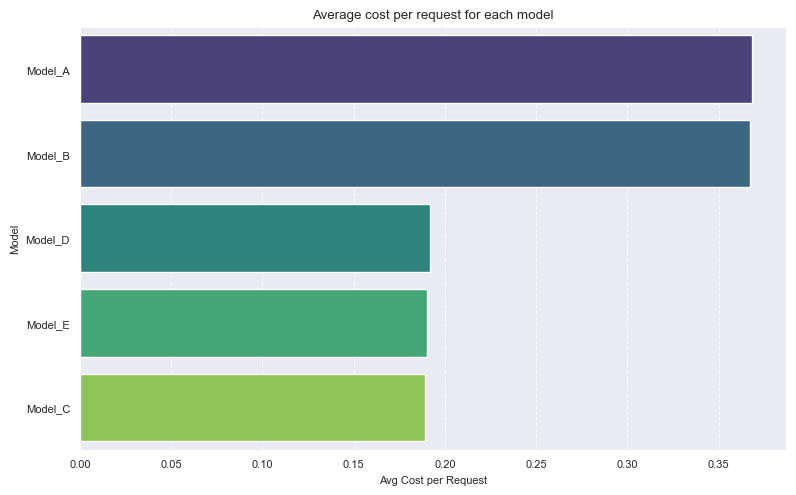

,model,total_requests,total_spent,mean_requests_per_day,median_requests_per_day,mean_spent_per_day,median_spent_per_day,avg_cost_per_request
0,Model_A,854633.0,314889.64,22.543141,17.0,8.306023,6.34,0.368450
1,Model_B,607421.0,222898.44,26.370626,21.0,9.676931,7.57,0.366959
3,Model_D,1644000.0,315761.48,67.559793,50.0,12.976144,9.90,0.192069
4,Model_E,720801.0,136983.83,56.617783,45.0,10.759864,8.48,0.190044
2,Model_C,1508946.0,285515.89,62.129781,48.0,11.755914,8.93,0.189215


In [585]:
by_model = (
    df.groupby('model')
    .agg(
        total_requests=('requests_cnt', 'sum'),
        total_spent=('spent_amount', 'sum'),
        mean_requests_per_day=('requests_cnt', 'mean'),
        median_requests_per_day=('requests_cnt', 'median'),
        mean_spent_per_day=('spent_amount', 'mean'),
        median_spent_per_day=('spent_amount', 'median')
    )
    .reset_index()
)

by_model['avg_cost_per_request'] = by_model['total_spent'] / by_model['total_requests']
by_model = by_model.sort_values('avg_cost_per_request', ascending=False)

# barplot
sns.barplot(
    data=by_model,
    x='avg_cost_per_request',
    y='model',
    hue = 'model',
    palette='viridis',
    legend = False
)
plt.title('Average cost per request for each model')
plt.xlabel('Avg Cost per Request')
plt.ylabel('Model')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

by_model

Models **A and B have a higher average cost per request**, which may imply that they are more resource-intensive (i.e., more advanced).

Models C, D, and E, on the other hand, are at a similar level of advancement.

### Average Cost per Request by Feature


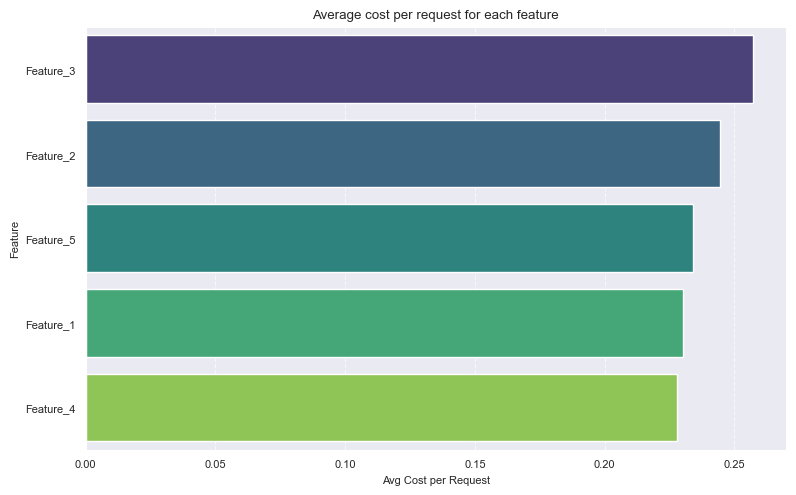

,feature,total_requests,total_spent,mean_requests_per_day,median_requests_per_day,mean_spent_per_day,median_spent_per_day,avg_cost_per_request
2,Feature_3,958529.0,246432.01,36.607432,29.0,9.411549,7.43,0.257094
1,Feature_2,1489475.0,364234.51,41.015421,31.0,10.029864,7.78,0.244539
4,Feature_5,259813.0,60799.47,35.363141,26.0,8.275414,6.59,0.234012
0,Feature_1,2293979.0,528453.66,50.702391,35.0,11.680083,8.73,0.230366
3,Feature_4,334005.0,76129.63,46.344526,37.0,10.563290,8.20,0.227930


In [586]:
by_feature = (
    df.groupby('feature')
    .agg(
        total_requests=('requests_cnt', 'sum'),
        total_spent=('spent_amount', 'sum'),
        mean_requests_per_day=('requests_cnt', 'mean'),
        median_requests_per_day=('requests_cnt', 'median'),
        mean_spent_per_day=('spent_amount', 'mean'),
        median_spent_per_day=('spent_amount', 'median')
    )
    .reset_index()
)

by_feature['avg_cost_per_request'] = by_feature['total_spent'] / by_feature['total_requests']
by_feature = by_feature.sort_values('avg_cost_per_request', ascending=False)

# barplot
sns.barplot(
    data=by_feature,
    x='avg_cost_per_request',
    y='feature',
    hue = 'feature',
    palette='viridis',
    legend = False
)
plt.title('Average cost per request for each feature')
plt.xlabel('Avg Cost per Request')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

by_feature

All features show a **similar average cost per request**, with features 3 and 2 being slightly above average, which may be due to the fact that they are more computationally complex or use a more advanced background model.

### What are the most commonly used combinations of models and functions? 

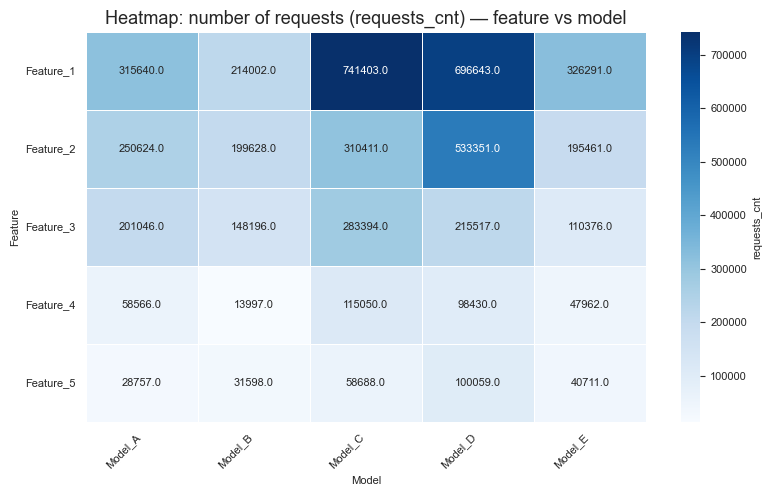

In [587]:
pivot_fm = pd.pivot_table(
    df,
    index='feature',
    columns='model',
    values='requests_cnt',
    aggfunc='sum',
    fill_value=0
)

# sorting so that the most active features are at the top
pivot_fm = pivot_fm.loc[pivot_fm.sum(axis=1).sort_values(ascending=False).index]

# heatmap
sns.heatmap(
    pivot_fm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'requests_cnt'},
)
plt.title('Heatmap: number of requests (requests_cnt) — feature vs model', fontsize=13)
plt.xlabel('Model')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The heatmap clearly demonstrates that **feature 1 in combination with models C and D** and **feature 2 in combination with model D** are the ones that attract **the most interest**. 

It is worth investigating this correlation, finding out why these combinations are the most used and developing features/models in this direction.

## What are the best combinations of models and features?

In [588]:
combo = df.groupby(['model','feature']).agg(
    total_requests=('requests_cnt','sum'),
    total_spent=('spent_amount','sum'),
    days=('day_id','nunique')
).reset_index()
combo['cost_per_request'] = combo['total_spent'] / combo['total_requests']

top5_requests = combo.sort_values('total_requests', ascending=False).head(5)
top5_spent = combo.sort_values('total_spent', ascending=False).head(5)
top5_cost_efficiency = combo.sort_values('cost_per_request').head(5) 

print("=== BEST FEATURE X MODEL COMBINATIONS ===")
print("\nTop 5 combinations (requests):\n", top5_requests)
print("\nTop 5 combinations (spent):\n", top5_spent)
print("\nTop 5 combinations (most cost-efficient):\n", top5_cost_efficiency)
print("\n\n")

=== BEST FEATURE X MODEL COMBINATIONS ===

Top 5 combinations (requests):
       model    feature  total_requests  total_spent  days  cost_per_request
10  Model_C  Feature_1        741403.0    138546.00    92          0.186870
15  Model_D  Feature_1        696643.0    135478.06    92          0.194473
16  Model_D  Feature_2        533351.0    100683.17    92          0.188775
20  Model_E  Feature_1        326291.0     62074.79    92          0.190244
0   Model_A  Feature_1        315640.0    114629.76    92          0.363166

Top 5 combinations (spent):
       model    feature  total_requests  total_spent  days  cost_per_request
10  Model_C  Feature_1        741403.0    138546.00    92          0.186870
15  Model_D  Feature_1        696643.0    135478.06    92          0.194473
0   Model_A  Feature_1        315640.0    114629.76    92          0.363166
16  Model_D  Feature_2        533351.0    100683.17    92          0.188775
1   Model_A  Feature_2        250624.0     92705.86    92  

## 6. Time-Based Trends

### Daily and Weekly Requests per Model/Feature

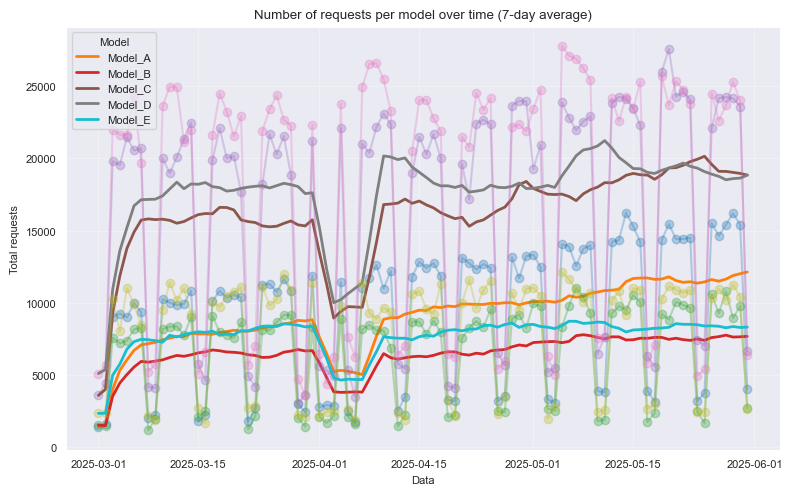

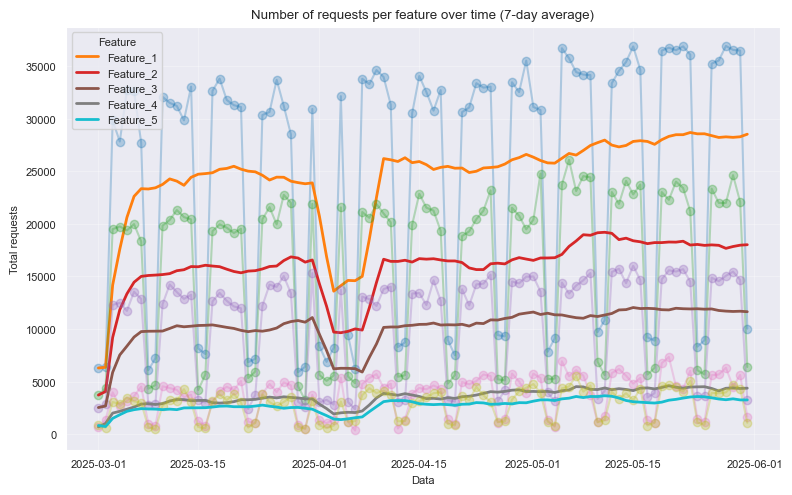

In [589]:
# daily aggregation per model
model_daily = df.groupby(['day_id', 'model']).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
models = model_daily['model'].unique()

# plot
for m in models:
    data = model_daily[model_daily['model'] == m].sort_values('day_id')
    data['rolling_7d_requests'] = data['total_requests'].rolling(7, min_periods=1).mean()
    plt.plot(data['day_id'], data['total_requests'], alpha=0.3, marker='o')
    # moving average
    plt.plot(data['day_id'], data['rolling_7d_requests'], label=m, linewidth=2)
plt.title('Number of requests per model over time (7-day average)')
plt.xlabel('Data')
plt.ylabel('Total requests')
plt.legend(title='Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# daily aggregation per feature
feature_daily = df.groupby(['day_id', 'feature']).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
features = feature_daily['feature'].unique()

# plot
for m in features:
    data = feature_daily[feature_daily['feature'] == m].sort_values('day_id')
    data['rolling_7d_requests'] = data['total_requests'].rolling(7, min_periods=1).mean()
    plt.plot(data['day_id'], data['total_requests'], alpha=0.3, marker='o')
    # moving average
    plt.plot(data['day_id'], data['rolling_7d_requests'], label=m, linewidth=2)
plt.title('Number of requests per feature over time (7-day average)')
plt.xlabel('Data')
plt.ylabel('Total requests')
plt.legend(title='Feature')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The above graphs reveal several observations:
- On weekends, the number of requests **drops** significantly, regardless of function or model.
- Over the period of three months, **the popularity of Model A and Model C increased**, with Model C becoming the most frequently used model at the end of the analyzed interval
- The popularity of none of the functions changed significantly
- At the beginning of April, there was a **sharp decline** in the number of requests over a few days, after which everything returned to the normal level

### Average Cost per Request Over Time

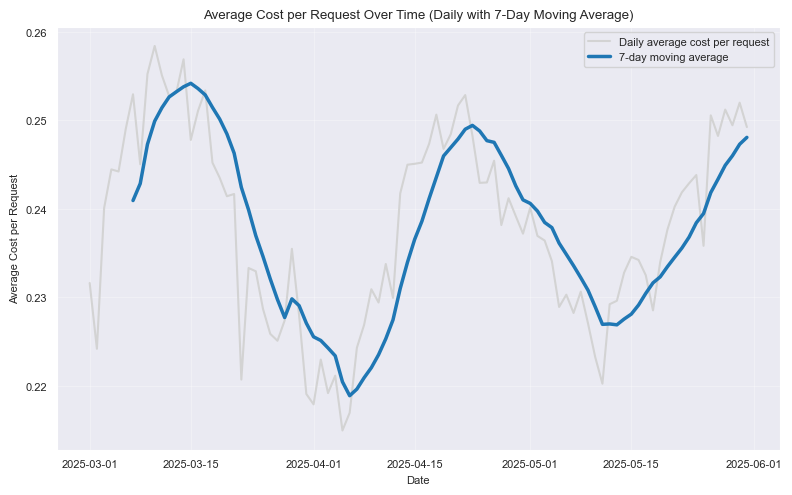

In [590]:
daily_cost = (
    df.groupby('day_id')
    .agg(
        total_spent=('spent_amount', 'sum'),
        total_requests=('requests_cnt', 'sum')
    )
    .reset_index()
)
daily_cost['avg_cost_per_request'] = daily_cost['total_spent'] / daily_cost['total_requests']

# 7-day moving average
daily_cost['avg_cost_7d'] = daily_cost['avg_cost_per_request'].rolling(window=7, center=False).mean()

# plot
plt.plot(
    daily_cost['day_id'],
    daily_cost['avg_cost_per_request'],
    color='lightgray',
    linewidth=1.5,
    label='Daily average cost per request'
)
plt.plot(
    daily_cost['day_id'],
    daily_cost['avg_cost_7d'],
    color='tab:blue',
    linewidth=2.5,
    label='7-day moving average'
)
plt.title('Average Cost per Request Over Time (Daily with 7-Day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Average Cost per Request')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

We can observe an unusual phenomenon – **cyclical increases and decreases in the average cost per request**. 

This may be due to the fact that users (or companies) return to the platform in waves — for example, they have periods of intense project work (resulting in an increased number of queries to advanced models), followed by a break. 

### Active Users & Retention Trends

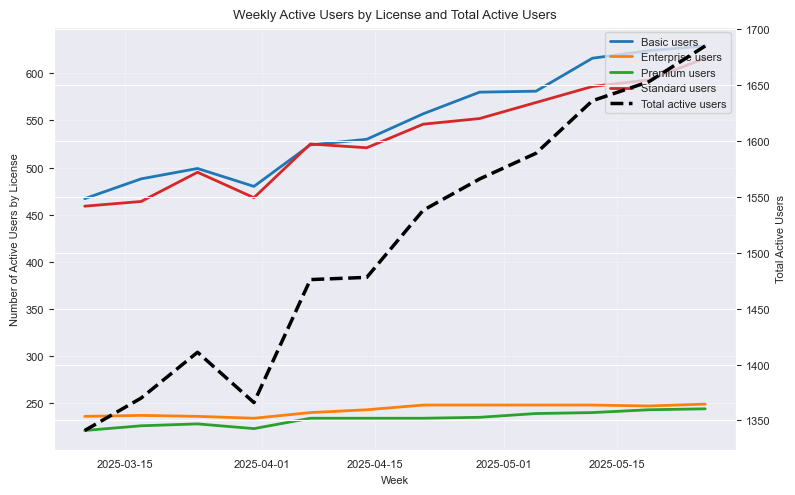

In [591]:
df['week'] = df['day_id'] - pd.to_timedelta(df['day_id'].dt.weekday, unit='D')

weekly_active = (
    df.groupby(['week', 'license'])['uuid']
    .nunique()
    .reset_index()
    .rename(columns={'uuid': 'active_users'})
)

# skip the first week
start_date = df['day_id'].min() + pd.Timedelta(days=7)
weekly_active_filtered = weekly_active[weekly_active['week'] >= start_date]

weekly_total = (
    df.groupby('week')['uuid']
    .nunique()
    .reset_index()
    .rename(columns={'uuid': 'total_users'})
)
weekly_total = weekly_total[weekly_total['week'] >= start_date]

# plot
fig, ax1 = plt.subplots(figsize=(8,5))
for lic in weekly_active_filtered['license'].unique():
    data = weekly_active_filtered[weekly_active_filtered['license'] == lic]
    ax1.plot(
        data['week'],
        data['active_users'],
        label=f"{lic} users",
        linewidth=2
    )
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of Active Users by License')
ax1.set_title('Weekly Active Users by License and Total Active Users')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(
    weekly_total['week'],
    weekly_total['total_users'],
    color='black',
    linestyle='--',
    linewidth=2.5,
    label='Total active users'
)
ax2.set_ylabel('Total Active Users')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

The **increase in the number of users** over these three months is evident. The basic and standard licenses gained the most users (relative to their original number of subscribers). 

### Activity by Day of the Week

<Axes: title={'center': 'Number of requests by day of the week'}, xlabel='weekday'>

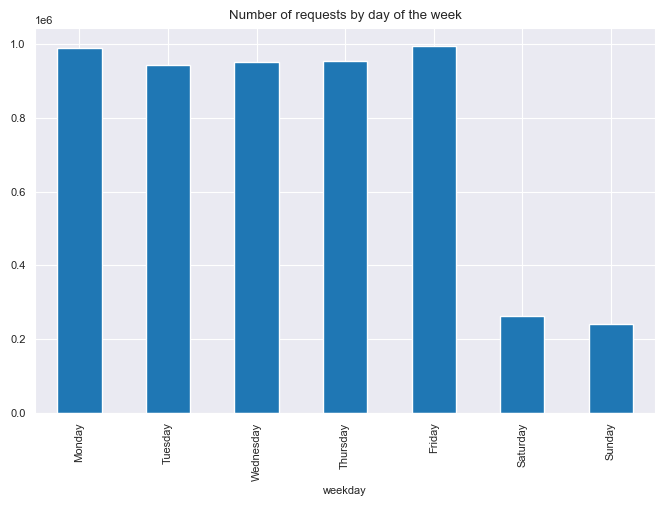

In [592]:
df['weekday'] = df['day_id'].dt.day_name()
weekday_stats = df.groupby('weekday')['requests_cnt'].sum().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])
weekday_stats.plot(kind='bar', title='Number of requests by day of the week')

We can observe **periodic declines** in activity on weekends, typical for professional environments.


## 7. Credit Spending Forecast

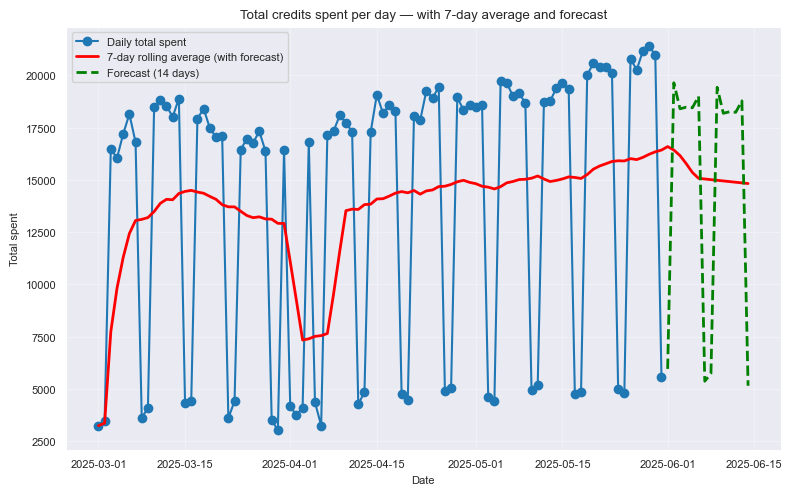

In [593]:
daily_cost = daily_cost.set_index('day_id').asfreq('D').fillna(0)
daily_cost['rolling_7d_spent'] = daily_cost['total_spent'].rolling(7, min_periods=1).mean()

model = ExponentialSmoothing(daily_cost['total_spent'], trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()
    
# forecast
forecast = fit.forecast(14)
forecast.index = pd.date_range(start=daily_cost.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')

combined = pd.concat([
    daily_cost[['total_spent']],
    forecast.rename('forecast')
])

combined['rolling_7d'] = combined['forecast'].combine_first(combined['total_spent']).rolling(7, min_periods=1).mean()

# plot
plt.plot(daily_cost.index, daily_cost['total_spent'], label='Daily total spent', marker='o')
plt.plot(combined.index, combined['rolling_7d'], label='7-day rolling average (with forecast)', color='red', linewidth=2)
plt.plot(forecast.index, forecast, label='Forecast (14 days)', color='green', linestyle='--', linewidth=2)
plt.title('Total credits spent per day — with 7-day average and forecast')
plt.xlabel('Date')
plt.ylabel('Total spent')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# General summary

---

### Users

Analysis of user data (March–May 2025) showed clear differences in activity, spending, and feature usage in the IDE.
 
Most users are not very active, the main revenue comes from a small group of the most engaged customers. 

Spending is strongly correlated with the number of queries, indicating proportional use of credits versus activity. 

The difference between licenses is significant—users of higher-tier packages (Premium, Enterprise) generate the vast majority of revenue despite having fewer accounts.

---

### Models & Features

The most frequently used models are C and D, and the most frequently used features are 1 and 2 — in combination, they are the most commonly used by clients. Models A and B are more costly but less popular, which may require some optimization. 

 ---
 
### Business recommendations:

 - **Focus on peak users** – retain and grow your most active customers through loyalty offers, priority support, and dedicated features,

 - **Reactivate dormant users** – use personalized notifications, periodic bonuses, or free credits to encourage them to return,

 - **Strengthen the license strategy** – promote upgrades from lower plans to higher ones through time-limited discounts and additional benefits in upgraded packages,

 - **Focus technical development** on the most used models (C and D) and features (1 and 2), which are the core value of the product,

 - **Consider differentiating prices** between models based on their computational costs and popularity to improve margins,

 - **Monitor spending patterns and activity** over time to identify changes in user behavior and potential churn risks at an early stage.

---

**The overall picture indicates that the greatest potential for growth lies in maintaining and developing top users as well as in optimizing prices and functionalities in terms of actual usage.**